In [1]:
import sys

sys.path.append("..")
sys.path.append("../../")
sys.path.append("../../src")

import main
import os
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functional_autoencoders.samplers.sampler_vae import SamplerVAE
from functional_autoencoders.util.random.sde import add_bm_noise
from functional_autoencoders.util import (
    yaml_load,
    pickle_load,
    bucket_data,
    get_transition_matrix,
)
from plots_sde2d import (
    plot_training_results,
    plot_contour_with_samples,
    plot_contour_with_reconstructions,
    plot_contour_and_heatmap,
    plot_contour_with_partitions,
)

# %load_ext autoreload
# %autoreload 2

# %matplotlib widget

key = jax.random.PRNGKey(42)

In [2]:
MODEL_OUT_DIR = "../../tmp/experiments/exp_sde2d/models"
CONFIG_PATH = "../configs/config_sde2d.yaml"

N_DATA_SAMPLES = 2**14

config_sde2d = yaml_load(CONFIG_PATH)
config_data = config_sde2d["data"]

_, test_dataloader = main.get_sde_dataloaders(
    config_data, verbose=True, samples=N_DATA_SAMPLES, which="test"
)
info = pickle_load(os.path.join(MODEL_OUT_DIR, "model.pkl"))
results = info["results"]
autoencoder = info["autoencoder"]
state = results["state"]

  0%|          | 0/24576 [00:00<?, ?it/s]

In [3]:
print(N_DATA_SAMPLES)

16384


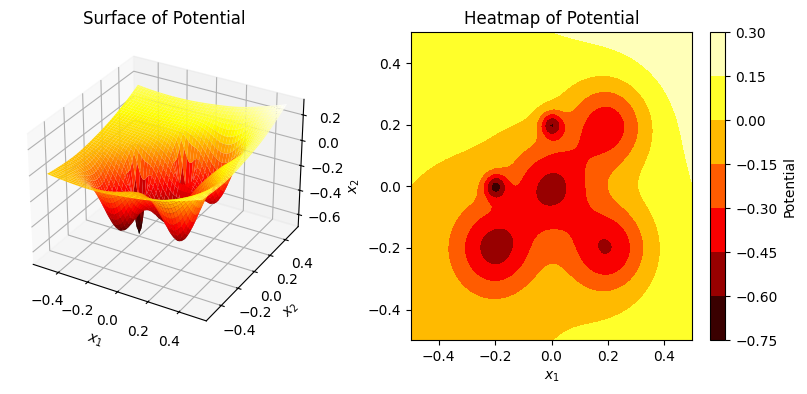

In [4]:
plot_contour_and_heatmap(main.potential_2d)
plt.show()

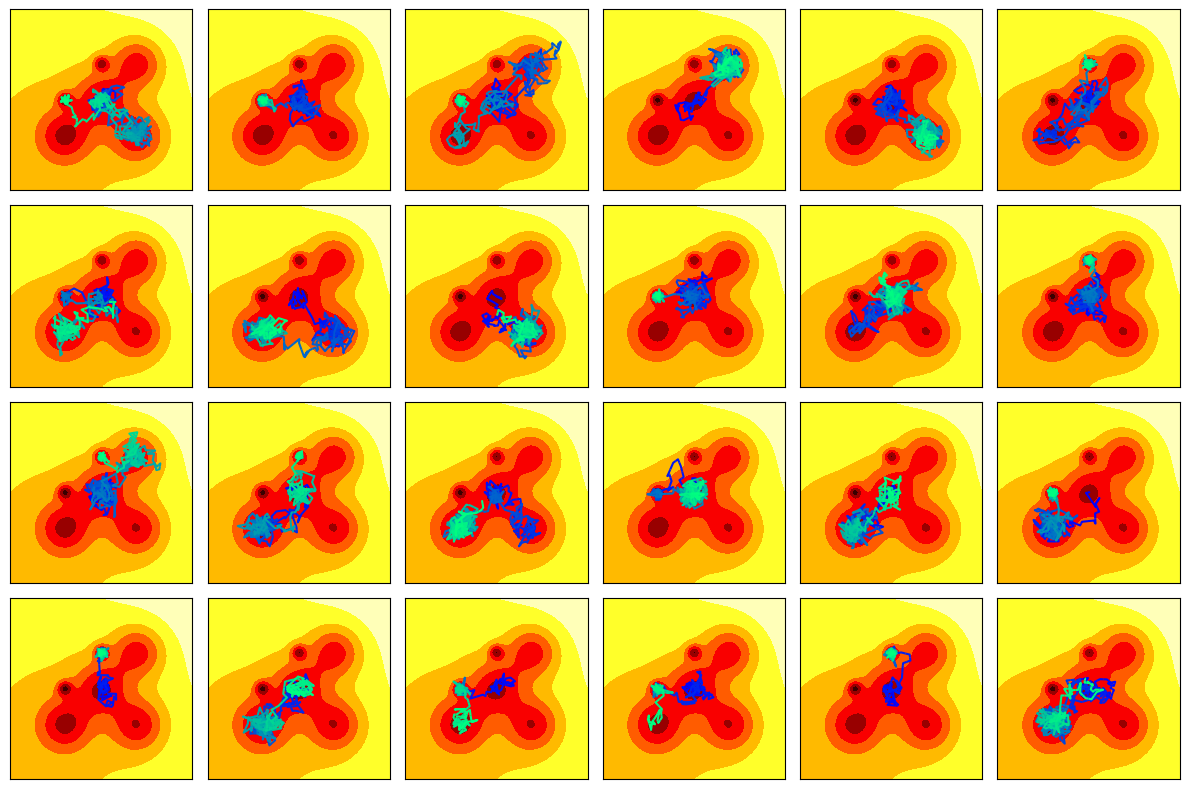

In [5]:
plt.rcParams["figure.figsize"] = [12, 8]

HEIGHT = 4
WIDTH = 6
SAVE_DIR = None
# SAVE_DIR = '../../figures/sde2d'
# os.makedirs(SAVE_DIR, exist_ok=True)

plot_contour_with_samples(
    test_dataloader.dataset.data["u"], main.potential_2d, HEIGHT, WIDTH
)

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/samples_dataset.jpg")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

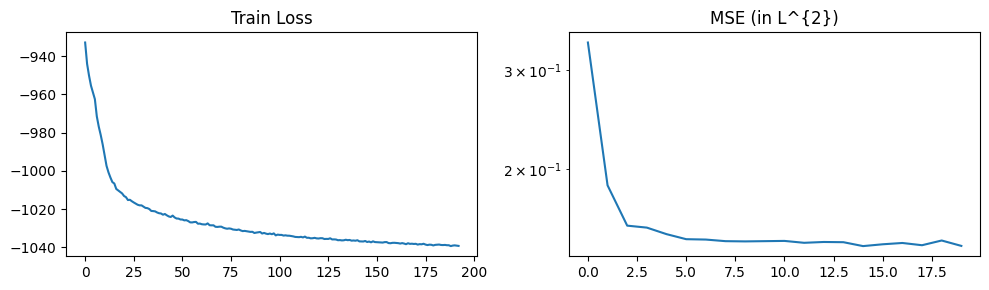

MSE (in L^{2}): 1.463e-01
Number of parameters: 53058


In [6]:
plt.rcParams["figure.figsize"] = [10, 3]

plot_training_results(results)

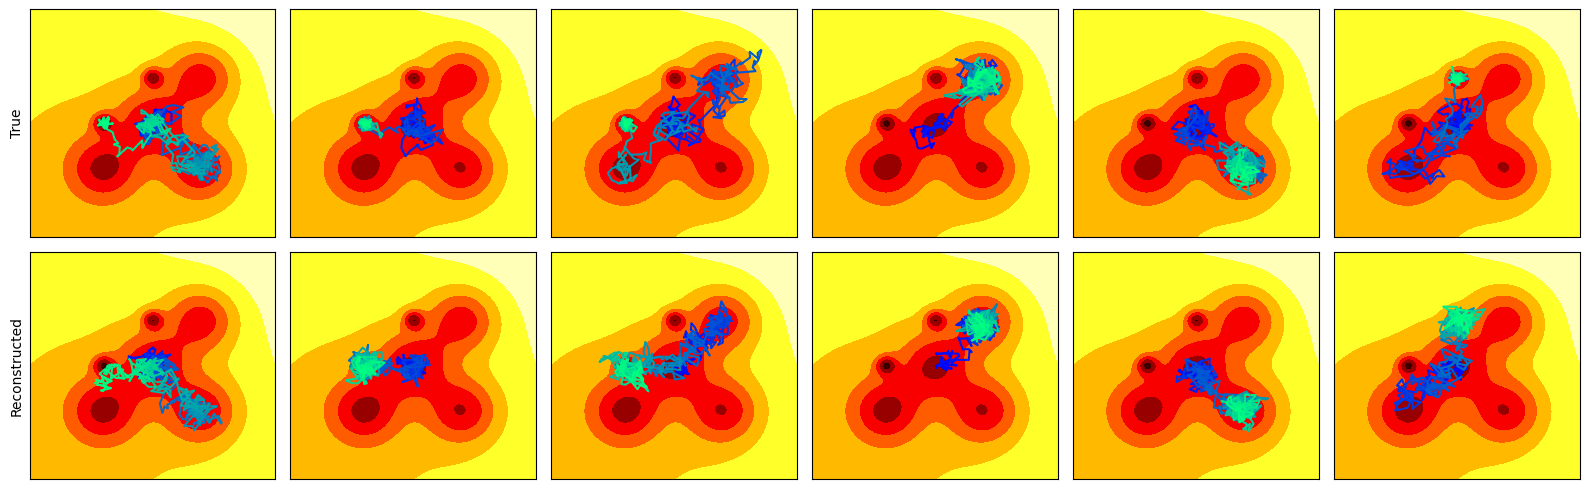

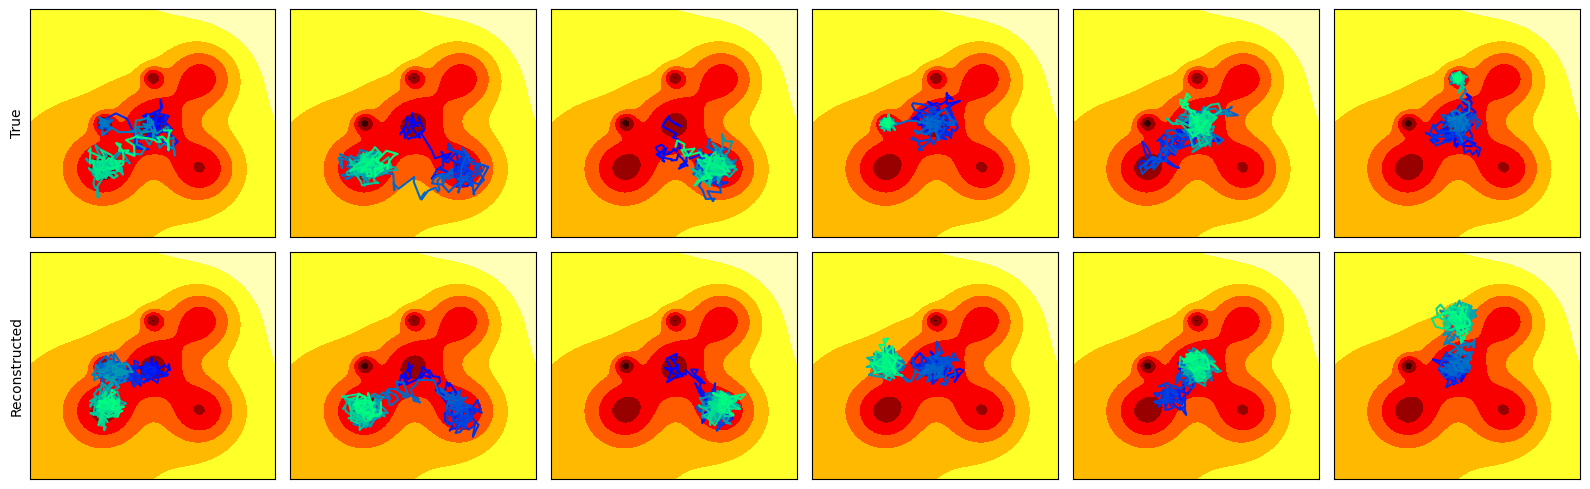

In [7]:
plt.rcParams["figure.figsize"] = [16, 5]

N_RECS = 6
SAVE_DIR = None
# SAVE_DIR = '../../figures/sde2d'
# os.makedirs(SAVE_DIR, exist_ok=True)

for i in range(2):
    u = jnp.array(test_dataloader.dataset.data["u"][i * N_RECS : (i + 1) * N_RECS])
    t_batch = jnp.repeat(test_dataloader.dataset.x[None, ...], u.shape[0], axis=0)

    u_rec = autoencoder.bind({"params": results["state"].params})(u, t_batch, t_batch)
    u_rec = add_bm_noise(
        samples=u_rec,
        epsilon=config_sde2d["data"]["epsilon"],
        theta=config_sde2d["loss"]["options"]["fvae_sde"]["theta"],
        sim_dt=config_sde2d["data"]["sim_dt"],
        T=config_sde2d["data"]["T"],
    )

    plot_contour_with_reconstructions(u, u_rec, main.potential_2d)
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/rec_{i}.pdf")
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

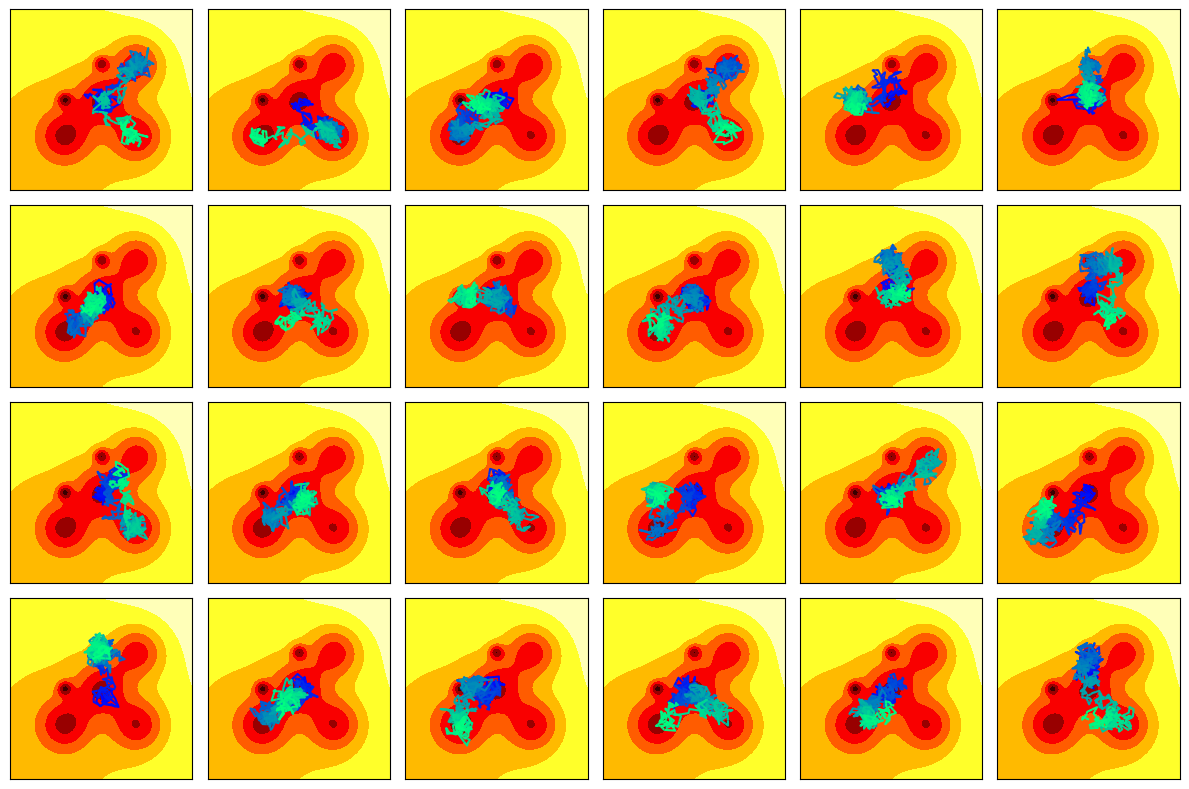

In [8]:
plt.rcParams["figure.figsize"] = [12, 8]

N_SAMPLES = 2**14
HEIGHT = 4
WIDTH = 6

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde2d'
# os.makedirs(SAVE_DIR, exist_ok=True)

u_test_short = jnp.array(test_dataloader.dataset.data["u"][:N_SAMPLES])

key, subkey = jax.random.split(key)
t_batch = jnp.repeat(
    test_dataloader.dataset.x[None, ...], u_test_short.shape[0], axis=0
)

key, subkey = jax.random.split(key)
sampler = SamplerVAE(autoencoder, results["state"])
u_samples = sampler.sample(t_batch, subkey)

u_samples = add_bm_noise(
    samples=u_samples,
    epsilon=config_sde2d["data"]["epsilon"],
    theta=config_sde2d["loss"]["options"]["fvae_sde"]["theta"],
    sim_dt=config_sde2d["data"]["sim_dt"],
    T=config_sde2d["data"]["T"],
)

plot_contour_with_samples(u_samples, main.potential_2d, HEIGHT, WIDTH)

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/samples_model.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

In [9]:
print(f"Number of short data samples: {u_test_short.shape[0]}")
print(f"Number of short model samples: {u_samples.shape[0]}")

Number of short data samples: 16384
Number of short model samples: 16384


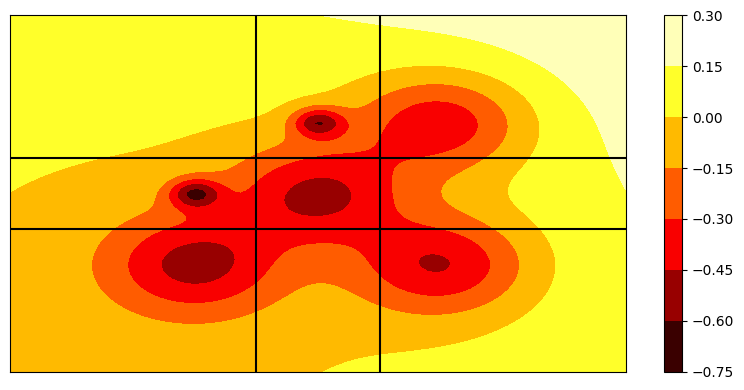

In [10]:
plt.rcParams["figure.figsize"] = [8, 4]

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde2d'
# os.makedirs(SAVE_DIR, exist_ok=True)

x_locs = [-9999, -0.1, 0.1, 9999]
y_locs = [-9999, -0.1, 0.1, 9999]

plot_contour_with_partitions(main.potential_2d, x_locs, y_locs)
if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/sde2d_potential.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

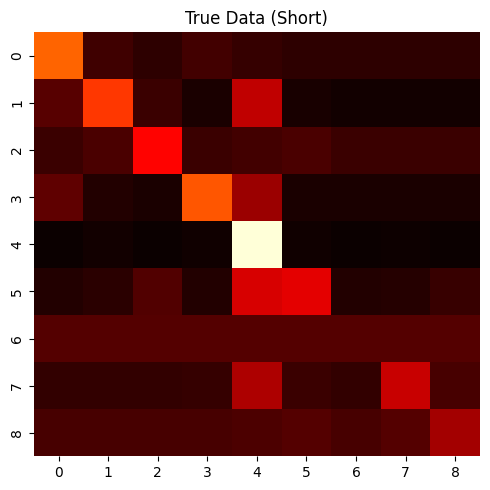

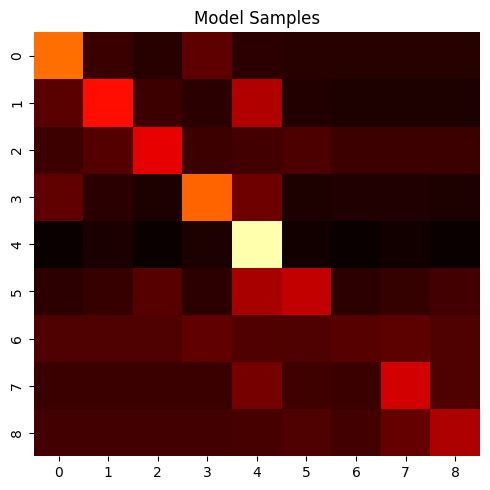

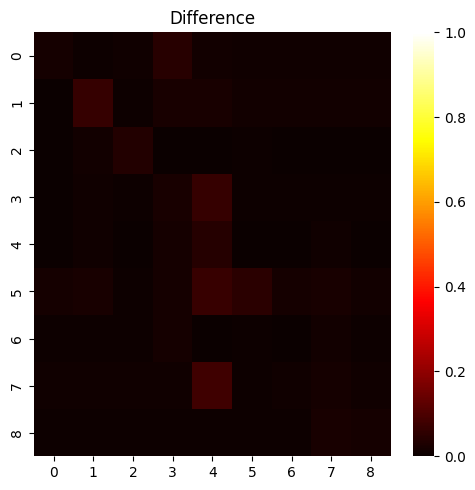

In [11]:
plt.rcParams["figure.figsize"] = [5, 5]

HEIGHT = 1
WIDTH = 3

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde2d'
# os.makedirs(SAVE_DIR, exist_ok=True)

n_buckets = (len(x_locs) - 1) * (len(y_locs) - 1)

u_bucket_true_short = bucket_data(u_test_short, x_locs, y_locs)
u_bucket_sample = bucket_data(u_samples, x_locs, y_locs)

transition_matrix_true_short = get_transition_matrix(
    u_bucket_true_short, n_buckets
).mean(0)
transition_matrix_samples = get_transition_matrix(u_bucket_sample, n_buckets).mean(0)

sns.heatmap(transition_matrix_true_short, cmap="hot", cbar=False, vmin=0, vmax=1)
plt.title("True Data (Short)")
if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/sde2d_true_data_short.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

sns.heatmap(transition_matrix_samples, cmap="hot", cbar=False, vmin=0, vmax=1)
plt.title("Model Samples")

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/sde2d_model_data_short.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

transition_diffs = jnp.abs(transition_matrix_samples - transition_matrix_true_short)
sns.heatmap(transition_diffs, cmap="hot", vmin=0, vmax=1)
plt.title("Difference")

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/sde2d_difference_short.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

In [12]:
trans_mat_short_vs_samples = jnp.linalg.norm(
    transition_matrix_true_short - transition_matrix_samples
)
print(f"Short vs samples: {trans_mat_short_vs_samples:.4f}")

Short vs samples: 0.1898
